# Clash Royale API Data Exploration

## I. Set up API connection

In [1]:
# import required libraries
import pandas as pd
import config
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
api_key = config.API_KEY

In [3]:
# set up api_key and base_url
header = {'Authorization' : f'Bearer {api_key}'
}
base_url = 'https://api.clashroyale.com/v1'

## II. Request data and transform into pandas DataFrame

In [4]:
# rankings last season - most recent available for call
response = requests.get(f'{base_url}/locations/global/pathoflegend/2025-02/rankings/players?limit=100', headers=header)
top_100 = []
for player in response.json()['items']:
    rank_info = {'player_id': player['tag'],
                 'rank' : player['rank']
    }
    top_100.append(rank_info)
rank_df = pd.DataFrame(top_100)    
rank_df['url_encoded_id'] = rank_df['player_id'].str.replace('#', '%23')
rank_df

,player_id,rank,url_encoded_id
0,#G9YV9GR8R,1,%23G9YV9GR8R
1,#CVU8GV292,2,%23CVU8GV292
2,#290VGG28,3,%23290VGG28
3,#RJ88Y8U08,4,%23RJ88Y8U08
4,#R90PRV0PY,5,%23R90PRV0PY
...,...,...,...
95,#CPGRQ8VQV,96,%23CPGRQ8VQV
96,#Y90CL0PCQ,97,%23Y90CL0PCQ
97,#8RYL09VJ,98,%238RYL09VJ
98,#202GUYUP,99,%23202GUYUP


In [5]:
# initialize lists for three data groups
battle_list = []
player_list = []
deck_list = []

# for every player in last season's top 100, extract out relevant data points from their battlelog
for player in rank_df['url_encoded_id']:
    response = requests.get(f'{base_url}/players/{player}/battlelog', headers=header)
    json_data = response.json()

    # extracts out battle details
    for battle in json_data:
        battle_info = {'battle_type': battle['type'],
                       'battle_time': battle['battleTime'],
                       'team_player_id': battle['team'][0]['tag'],
                       'arena': battle['arena']['name'],
                       'game_mode': battle['gameMode']['name'],
                       'is_ladder_tournament': battle['isLadderTournament'],
                       'is_hosted_match': battle['isHostedMatch'],
                       'league': battle['leagueNumber'],    
        }
        battle_list.append(battle_info)
        
        # extracts out player & player results details 
        for player_type, player_data in zip(['team', 'opponent'], [battle['team'], battle['opponent']]):
            team_info = {'battle_time': battle['battleTime'],
                         'battle_type': battle['type'],
                         'player_type': player_type,
                         'player_id':   player_data[0]['tag'],
                         'player_name': player_data[0]['name'],
                         'clan_name': player_data[0].get('clan', {}).get('name', None),
                         'global_rank': player_data[0].get('globalRank', 'Unranked'),
                         'start_trophy': player_data[0].get('startingTrophies', None),
                         'trophy_change': player_data[0].get('trophyChange', None),
                         'crowns': player_data[0]['crowns'],
                         'king_tower_hp': player_data[0].get('kingTowerHitPoints', 0),
                         'princess_tower_hp': player_data[0].get('princessTowersHitPoints', None),                     
                         'elixir_leaked': player_data[0]['elixirLeaked']                     
            }
            player_list.append(team_info)
            
            # extracts out deck & card details 
            for card in player_data[0]['cards']:
                card_info = {'battle_time': battle['battleTime'],
                             'battle_type': battle['type'],
                             'player_id': player_data[0]['tag'],
                             'player_type': player_type,
                             'card_id': card['id'],
                             'card_name': card['name'],
                             'card_level': card['level'],
                             'elixir_cost': card.get('elixirCost', None),
                             'rarity': card['rarity']         
                }
    
                deck_list.append(card_info)

battle_df = pd.DataFrame(battle_list)   
player_df = pd.DataFrame(player_list)
deck_df = pd.DataFrame(deck_list)

## III. Data cleaning

In [6]:
current_season = pd.Series(['2025-03-03 10:00', '2025-04-07 10:00']) # defining range of date aligned with current season
current_season = pd.to_datetime(current_season, format='%Y-%m-%d %H:%M')

for table in [battle_df, player_df, deck_df]:
    table['battle_time'] = pd.to_datetime(table['battle_time'], format='%Y%m%dT%H%M%S.000Z')
battle_df = battle_df.copy()
battle_df = battle_df[battle_df['battle_type'] == 'pathOfLegend'] # limit scope to path of legends ladder
battle_df = battle_df[battle_df['battle_time'].between(current_season[0], current_season[1])] # using season range to filter
battle_df.sort_values('battle_time', inplace=True)
battle_df.reset_index(inplace=True, drop=True)

player_df = player_df.copy()
player_df = player_df[player_df['battle_type'] == 'pathOfLegend']
player_df['p_tower1_hp'] = player_df['princess_tower_hp'].astype('str').str.split(',').str[0].str.replace('[', '').str.replace(']', '') # split princess tower hp list into two cols
player_df['p_tower2_hp'] = player_df['princess_tower_hp'].astype('str').str.split(',').str[1].str.replace('[', '').str.replace(']', '')
player_df['p_tower1_hp'] = player_df['p_tower1_hp'].mask(player_df['p_tower1_hp'] == 'None', 0)
player_df['p_tower2_hp'] = player_df['p_tower2_hp'].mask(player_df['p_tower2_hp'].isnull(), 0)
player_df['p_tower1_hp'] = player_df['p_tower1_hp'].astype('int')
player_df['p_tower2_hp'] = player_df['p_tower2_hp'].astype('int')
player_df = player_df[player_df['battle_time'].between(current_season[0], current_season[1])]
player_df['end_trophy'] = player_df['start_trophy'] + player_df['trophy_change']

# separate team and opponent player data
team_df = player_df[player_df['player_type'] == 'team'].copy()
opponent_df = player_df[player_df['player_type'] == 'opponent'].copy()

# Merge team and opponent on battle_time - gets rows to be unique battle
merged_player_df = pd.merge(team_df, opponent_df, on='battle_time',
                            suffixes=('_team', '_opponent'), how='inner')

# create function to create match result cols
def match_result(crowns_team, crowns_opponent):
    if crowns_team > crowns_opponent:
        return 'W'
    elif crowns_team < crowns_opponent:
        return 'L'
    else:
        return 'T'

# Apply the function row-wise to determine the outcome for both team and opponent
merged_player_df['outcome_team'] = merged_player_df.apply(
    lambda row: match_result(row['crowns_team'], row['crowns_opponent']), axis=1)

merged_player_df['outcome_opponent'] = merged_player_df.apply(
    lambda row: match_result(row['crowns_opponent'], row['crowns_team']), axis=1)

merged_player_df.drop(['battle_type_team', 'player_type_team', 'player_type_opponent'], axis=1, inplace=True)
merged_player_df.sort_values('battle_time', inplace=True)
merged_player_df.drop_duplicates(subset=['battle_time', 'player_id_team'], inplace=True)
merged_player_df.reset_index(inplace=True, drop=True)

deck_df = deck_df.copy()
deck_df = deck_df[deck_df['battle_type'] == 'pathOfLegend']
deck_df = deck_df[deck_df['battle_time'].between(current_season[0], current_season[1])]
deck_df.sort_values('battle_time', inplace=True)
deck_df.reset_index(inplace=True, drop=True)

# separate team and opponent deck data
team_deck_df = deck_df[deck_df['player_type'] == 'team'].copy()
opponent_deck_df = deck_df[deck_df['player_type'] == 'opponent'].copy()

In [7]:
battle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   battle_type           597 non-null    object        
 1   battle_time           597 non-null    datetime64[ns]
 2   team_player_id        597 non-null    object        
 3   arena                 597 non-null    object        
 4   game_mode             597 non-null    object        
 5   is_ladder_tournament  597 non-null    bool          
 6   is_hosted_match       597 non-null    bool          
 7   league                597 non-null    int64         
dtypes: bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 29.3+ KB


In [8]:
merged_player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   battle_time                 597 non-null    datetime64[ns]
 1   player_id_team              597 non-null    object        
 2   player_name_team            597 non-null    object        
 3   clan_name_team              473 non-null    object        
 4   global_rank_team            453 non-null    float64       
 5   start_trophy_team           506 non-null    float64       
 6   trophy_change_team          581 non-null    float64       
 7   crowns_team                 597 non-null    int64         
 8   king_tower_hp_team          597 non-null    int64         
 9   princess_tower_hp_team      539 non-null    object        
 10  elixir_leaked_team          597 non-null    float64       
 11  p_tower1_hp_team            597 non-null    int64         

In [9]:
team_deck_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4776 entries, 1 to 9551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   battle_time  4776 non-null   datetime64[ns]
 1   battle_type  4776 non-null   object        
 2   player_id    4776 non-null   object        
 3   player_type  4776 non-null   object        
 4   card_id      4776 non-null   int64         
 5   card_name    4776 non-null   object        
 6   card_level   4776 non-null   int64         
 7   elixir_cost  4776 non-null   float64       
 8   rarity       4776 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 373.1+ KB


In [10]:
opponent_deck_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4776 entries, 0 to 9544
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   battle_time  4776 non-null   datetime64[ns]
 1   battle_type  4776 non-null   object        
 2   player_id    4776 non-null   object        
 3   player_type  4776 non-null   object        
 4   card_id      4776 non-null   int64         
 5   card_name    4776 non-null   object        
 6   card_level   4776 non-null   int64         
 7   elixir_cost  4769 non-null   float64       
 8   rarity       4776 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 373.1+ KB


## IV. Exploratory data analysis

In [11]:
# selecting test player to run eda
test_player_df = merged_player_df[merged_player_df['player_id_team'] == '#JYG0G0Y9P']

# creating col for running win rate for player
test_player_df = test_player_df.copy()
test_player_df.reset_index(drop=True, inplace=True)
test_player_df['is_win'] = (test_player_df['outcome_team'] == 'W').astype(int)
test_player_df['cumulative_wins'] = test_player_df['is_win'].cumsum()
test_player_df['running_winrate'] = test_player_df['cumulative_wins'] / (test_player_df.index + 1)

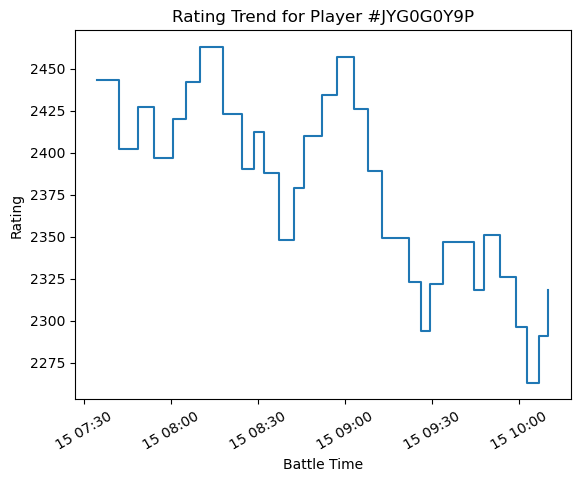

In [12]:
# rating over recent battlelog
plt.step(test_player_df['battle_time'], test_player_df['end_trophy_team'], where='post')
plt.title('Rating Trend for Player #JYG0G0Y9P')
plt.xlabel('Battle Time')
plt.xticks(rotation=30)
plt.ylabel('Rating')
plt.show()

In [13]:
# outcome last 5 matches (top = most recent match)
test_player_df['outcome_team'].tail()[::-1]

29    W
28    W
27    L
26    L
25    L
Name: outcome_team, dtype: object

In [14]:
# last 5 log
test_player_df.tail()[::-1].loc[:, ['battle_time', 'player_name_team', 'crowns_team', 'trophy_change_team',
                                    'player_name_opponent', 'crowns_opponent', 'trophy_change_opponent', 'outcome_team']]

,battle_time,player_name_team,crowns_team,trophy_change_team,player_name_opponent,crowns_opponent,trophy_change_opponent,outcome_team
29,2025-03-15 10:10:05,LonDex Play,1,27.0,Tóm,0,-27.0,W
28,2025-03-15 10:06:47,LonDex Play,3,28.0,MASTER.,1,-28.0,W
27,2025-03-15 10:02:49,LonDex Play,0,-33.0,OTP Dooley,1,33.0,L
26,2025-03-15 09:58:59,LonDex Play,1,-30.0,momo,2,30.0,L
25,2025-03-15 09:53:31,LonDex Play,0,-25.0,kangdone,1,25.0,L


In [15]:
# finds longest win streak
def longest_win_streak(series):
    # create a grouping variable that increments when a loss (L) occurs, consecutive wins get same number
    streak_group = (series != 'W').cumsum()

    # filter for only wins (W), groups wins by streak, then counts length of streak
    win_streaks = series[series == 'W'].groupby(streak_group).size()

    # return the longest streak or 0 if no wins 
    return win_streaks.max() if not win_streaks.empty else 0

longest_streak = longest_win_streak(test_player_df['outcome_team'])
print("Longest win streak:", longest_streak)

Longest win streak: 4


In [16]:
# winrate over log
round(test_player_df['is_win'].sum() / len(test_player_df['is_win'])* 100, 2)

50.0

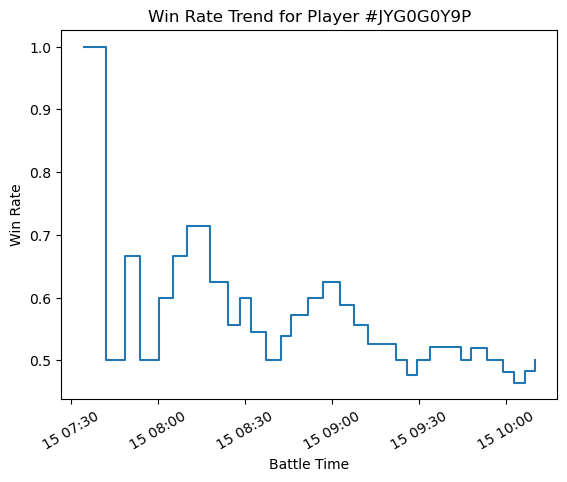

In [17]:
plt.step(test_player_df['battle_time'], test_player_df['running_winrate'], where='post')
plt.title('Win Rate Trend for Player #JYG0G0Y9P')
plt.xlabel('Battle Time')
plt.xticks(rotation=30)
plt.ylabel('Win Rate')
plt.show()

In [18]:
# elixir leaked and crowns per game summary stats
test_player_df[['elixir_leaked_team', 'crowns_team']].describe()

,elixir_leaked_team,crowns_team
count,30.000000,30.000000
mean,1.672667,0.900000
std,2.029875,0.844863
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.960000,1.000000
75%,2.470000,1.000000
max,7.240000,3.000000


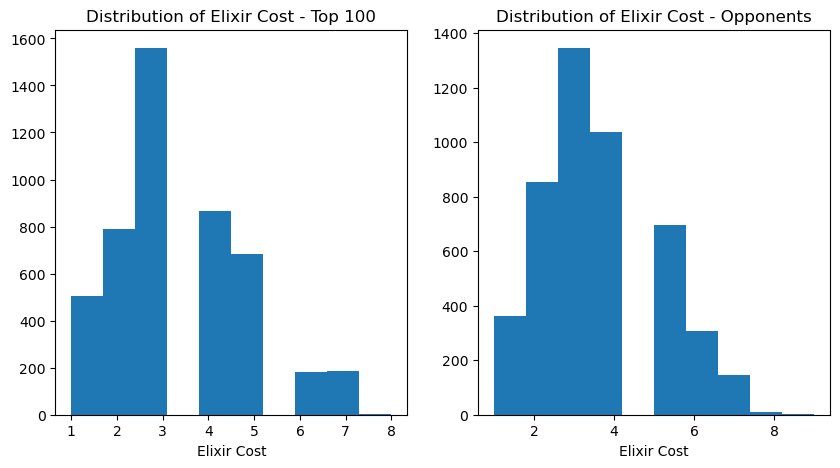

In [19]:
# elixir cost distribution of used cards - top 100 (team) vs opp
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].hist(team_deck_df['elixir_cost'])
axes[0].set_xlabel('Elixir Cost')
axes[0].set_title('Distribution of Elixir Cost - Top 100')
axes[1].hist(opponent_deck_df['elixir_cost'])
axes[1].set_xlabel('Elixir Cost')
axes[1].set_title('Distribution of Elixir Cost - Opponents')

plt.show()

In [20]:
# card usage rates among top 100 group
usage_rates_team = (team_deck_df.groupby('card_name')['battle_time'].count() / len(battle_df)).sort_values(ascending=False)
usage_rates_team

card_name
Cannon          0.350084
Ice Spirit      0.341709
The Log         0.319933
Arrows          0.318258
Skeletons       0.303183
                  ...   
Golem           0.003350
Mother Witch    0.001675
Berserker       0.001675
Ice Golem       0.001675
Minions         0.001675
Name: battle_time, Length: 97, dtype: float64

In [21]:
# card usage rates among opp
usage_rates_opp = (opponent_deck_df.groupby('card_name')['battle_time'].count() / len(battle_df)).sort_values(ascending=False)
usage_rates_opp

card_name
The Log              0.328308
Skeletons            0.241206
Tornado              0.239531
Lumberjack           0.239531
Arrows               0.226131
                       ...   
Three Musketeers     0.006700
Goblin Demolisher    0.003350
Suspicious Bush      0.003350
Clone                0.003350
Goblin Machine       0.001675
Name: battle_time, Length: 115, dtype: float64

In [22]:
# card win rates among top 100
team_deck_player_merge = team_deck_df.merge(merged_player_df, how='left', on='battle_time')
win_rates_team = (team_deck_player_merge[team_deck_player_merge['outcome_team'] == 'W']['card_name'].value_counts() / team_deck_df.groupby('card_name')['battle_time'].count()).sort_values(ascending=False)
win_rates_team

card_name
Goblin Giant    1.000000
Golem           1.000000
Rune Giant      1.000000
Bandit          1.000000
Mega Knight     1.000000
                  ...   
Princess        0.461538
Cannon Cart     0.444444
Wizard          0.333333
Berserker            NaN
Ice Golem            NaN
Length: 97, dtype: float64

In [23]:
# card win rates among opp
opp_deck_player_merge = opponent_deck_df.merge(merged_player_df, how='left', on='battle_time')
win_rates_opp = (opp_deck_player_merge[opp_deck_player_merge['outcome_opponent'] == 'W']['card_name'].value_counts() / opponent_deck_df.groupby('card_name')['battle_time'].count()).sort_values(ascending=False)
win_rates_opp

card_name
Furnace              0.500000
Suspicious Bush      0.500000
Mother Witch         0.478261
Night Witch          0.473684
Goblinstein          0.470588
                       ...   
Berserker                 NaN
Clone                     NaN
Fire Spirit               NaN
Goblin Demolisher         NaN
Goblin Machine            NaN
Length: 115, dtype: float64

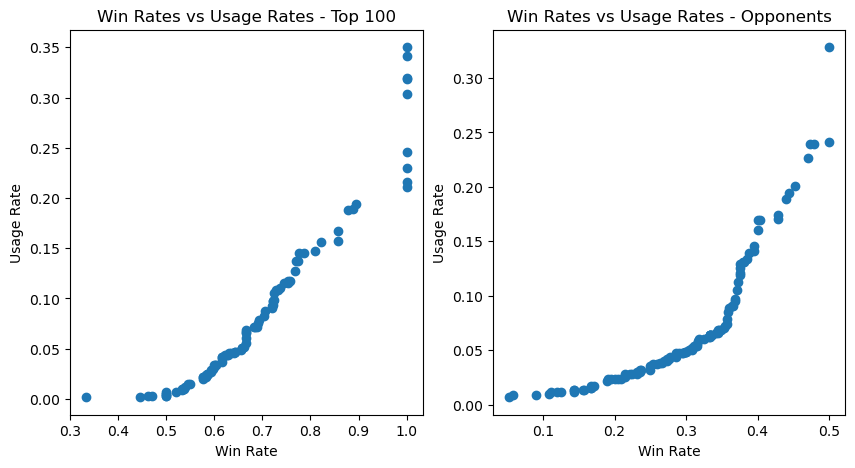

In [24]:
# win rates vs usage rates - top 100 vs opp
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, group, win_dfs, usage_dfs in zip(axes,
                                         ['Top 100', 'Opponents'],
                                         [win_rates_team, win_rates_opp],
                                         [usage_rates_team, usage_rates_opp]):
    ax.scatter(win_dfs, usage_dfs)
    ax.set_title(f'Win Rates vs Usage Rates - {group}')
    ax.set_xlabel('Win Rate')
    ax.set_ylabel('Usage Rate')

plt.show()

## V. Table exports

In [25]:
# merged_player_df.to_excel('merged_player_df.xlsx', index=False)
# team_deck_df.to_excel('team_deck_df.xlsx', index=False)
# opponent_deck_df.to_excel('opp_deck_df.xlsx', index=False)